1. Load Libraries

In [1]:
from scripts import *

Checking cuda

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

3. Create PyTorch data generators

In [3]:
# train_path = "/home/sougato97/documents/hand_vein/datasets/Javierian_U/train"
train_path = "/home/sougato97/documents/hand_vein/datasets/Dataset_split/train"

transformation = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.75),
    transforms.RandomRotation(10),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

folder_dataset = datasets.ImageFolder(root=train_path)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

# only for vizualization 
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=2,
                        batch_size=8)


3A. Total no. of classes

In [4]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

3B. Extract one batch (only for visualization)

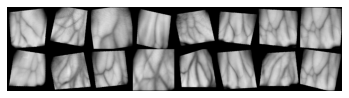

[1. 1. 1. 1. 1. 0. 1. 0.]


In [5]:
example_batch = next(iter(vis_dataloader))

# sougat0-doubt - how is it getting 2x8 = 16 images ? ANS - batch_size = 8 in the DataLoader
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1)) 

Labels :-
- 0 for the same class
- 1 if diff class

4A. Create PyTorch train data generators

In [6]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=64)

model_trained = SiameseNetwork().cuda()
# trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
# trainer.fit(model_trained)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model_trained.parameters(), lr = 0.001 )

4B. Create the test data generator

In [7]:
# test_path = "/home/sougato97/documents/hand_vein/datasets/Javierian_U/test"
test_path = "/home/sougato97/documents/hand_vein/datasets/Dataset_split/val"
folder_test_dataset = datasets.ImageFolder(root=test_path)
test_dataset = SiameseNetworkDataset(imageFolderDataset=folder_test_dataset,
                                        transform=transformation)

test_dataloader = DataLoader(test_dataset,
                        shuffle=True,
                        batch_size=64)

4C. Transfer Learning (if the user gives the input)

In [8]:
user_ip = 1
if(user_ip == 1):
    load_model_path = './saved_models/siamese_split.pth'
    model_trained, optimizer, prev_epoch, criterion, prev_loss = load_model(model_trained, load_model_path)
    # prev_loss = 0.3383013606071472
else:
    prev_epoch = 0
    prev_accuracy = 0
    prev_loss = 10000.0

5. Train Siamese

In [9]:
# counter = []
# loss_history = [] 
# iteration_number= 0
# no_epochs = 400
# PATH = os.getcwd()+'/saved_models/best_siamese.model'

In [10]:
# my algorithm for accuracy :-
# need to iterate for all the images(img2 in test folder) vs 1 image(img1 from validation)
# find out the img2 having minimum distance with min img1
# if label == 1 then 
#     wrong output

In [11]:
# This is only temporary
# prev_loss = 0.08317045867443085

5A. Model save wrt min contrastive loss

In [12]:
train_loss_arr = []
test_loss_arr = []
x_axis = []
saved_model_loss = 10000
total_epochs = 300
min_test_loss = prev_loss
loss_history = [] 
iteration_number = 0
# Iterate throught the epochs
for epoch in range(total_epochs):
    # train the model 
    model_trained, counter, loss_history, iteration_number, present_loss = \
        train_siamese_wrt_loss(train_dataloader,model_trained,criterion,optimizer,epoch,counter,loss_history, \
            iteration_number)
    # test the model 
    test_loss, test_loss_arr = test_siamese_wrt_loss(test_dataloader,model_trained,test_loss_arr,criterion)
    print(f'Total Epoch {prev_epoch + epoch+1} Present Epoch {epoch+1} \n-----------------------------')
    print("Loss::: Train- ",present_loss," Test- ",test_loss)
    x_axis.append(epoch+1)
    # save best model with min test loss
    if (test_loss < min_test_loss):
        min_test_loss = test_loss
        print("Model saved at test loss :-",test_loss)
        save_model(prev_epoch + epoch, model_trained, optimizer, criterion, min_test_loss,'./saved_models/siamese_split.pth')
        saved_model_loss = min_test_loss
print("Best model is saved with :- \nLoss - ",saved_model_loss)
# show_plot(x_axis, test_loss_arr, "Epoch v/s Test Loss")

Total Epoch 2 Present Epoch 1 
-----------------------------
Loss::: Train-  0.4557184875011444  Test-  0.43787169456481934
Total Epoch 3 Present Epoch 2 
-----------------------------
Loss::: Train-  0.2372952699661255  Test-  0.4455612897872925
Total Epoch 4 Present Epoch 3 
-----------------------------
Loss::: Train-  0.40420296788215637  Test-  0.3323574364185333
Model saved at test loss :- 0.3323574364185333
Total Epoch 5 Present Epoch 4 
-----------------------------
Loss::: Train-  0.28756630420684814  Test-  0.7149612903594971
Total Epoch 6 Present Epoch 5 
-----------------------------
Loss::: Train-  0.5450014472007751  Test-  0.4509055018424988
Total Epoch 7 Present Epoch 6 
-----------------------------
Loss::: Train-  0.4559837281703949  Test-  0.3628592789173126
Total Epoch 8 Present Epoch 7 
-----------------------------
Loss::: Train-  0.5317432880401611  Test-  0.48918354511260986
Total Epoch 9 Present Epoch 8 
-----------------------------
Loss::: Train-  0.478670746

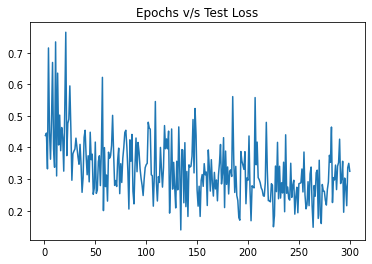

In [13]:
show_plot(x_axis, test_loss_arr, "Test Loss")

The following modules are not required

5C. Model saved wrt wrong accuracy calculation 

Epoch 37
-----------------------------
Accuracy::: Train-  49.51690821256038  Test-  50.14749262536873
Epoch 38
-----------------------------
Accuracy::: Train-  51.328502415458935  Test-  49.11504424778761
Epoch 39
-----------------------------
Accuracy::: Train-  49.15458937198068  Test-  50.0
Epoch 40
-----------------------------
Accuracy::: Train-  51.81159420289855  Test-  53.687315634218294
Epoch 41
-----------------------------
Accuracy::: Train-  51.57004830917874  Test-  48.67256637168141
Epoch 42
-----------------------------
Accuracy::: Train-  52.65700483091788  Test-  52.50737463126843
Epoch 43
-----------------------------
Accuracy::: Train-  48.429951690821255  Test-  52.21238938053098
Epoch 44
-----------------------------
Accuracy::: Train-  52.05314009661836  Test-  50.29498525073747
Epoch 45
-----------------------------
Accuracy::: Train-  51.328502415458935  Test-  50.442477876106196
Epoch 46
-----------------------------
Accuracy::: Train-  51.08695652173913  Tes

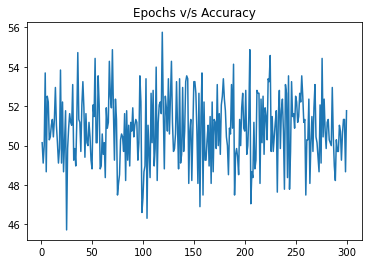

In [10]:
# modified version of the old training loop 
train_acc_arr = []
test_acc_arr = []
x_axis = []
saved_model_loss = 10000
total_epochs = 300
min_test_accuracy = prev_accuracy
# Iterate throught the epochs
for epoch in range(total_epochs):
    # train the model 
    model_trained, counter, loss_history, iteration_number, train_acc, train_acc_arr, present_loss = \
        train_siamese(train_dataloader,model_trained,criterion,optimizer,epoch,counter,loss_history, \
            iteration_number,train_acc_arr)
    # test the model 
    test_accuracy, test_acc_arr = test_siamese(test_dataloader,model_trained,test_acc_arr)
    print(f'Total Epoch {prev_epoch + epoch+1} Present Epoch {epoch+1} \n-----------------------------')
    print("Accuracy::: Train- ",train_acc," Test- ",test_accuracy)
    x_axis.append(epoch+1)
    # save best model with max test accuracy
    if (test_accuracy > min_test_accuracy):
        min_test_accuracy = test_accuracy
        print("Model saved at test accuracy :-",test_accuracy)
        save_model_wrt_accr(prev_epoch + epoch, model_trained, optimizer, criterion, test_accuracy, './saved_models/siamese_new.pth')
        saved_model_loss = present_loss
print("Best model is saved with :- \nLoss - ",saved_model_loss," ----- Test Accuracy - ",min_test_accuracy)
show_plot(x_axis, test_acc_arr, "Epoch v/s Test Accuracy")

In [13]:
present_loss

0.16838449239730835

In [15]:
min_test_accuracy

55.75221238938053

In [14]:
saved_model_loss

0.38831767439842224

Model train loop wrt contrastive loss

In [9]:
# Old training loop

min_loss = 10000.0 # infinity
# Iterate throught the epochs
for epoch in range(no_epochs):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = model_trained(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)
        
        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f'Epoch {epoch+1}\n-----------------------------')
            print(f"Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

        # Save the model with minimum loss
        if (loss_contrastive.item()<min_loss):
            min_loss = loss_contrastive.item()
            # overwrite if save previously made
            # torch.save(model_trained.state_dict(), PATH)
            save_model(epoch, model_trained, optimizer, loss_contrastive.item(),'./saved_models/siamese_model_wrt_loss.pth')

print("Best model is saved with loss of ",min_loss)
show_plot(counter, loss_history, "loss")

Epoch 1
-----------------------------
Current loss 1.8732643127441406

Epoch 1
-----------------------------
Current loss 0.7926465272903442

Epoch 2
-----------------------------
Current loss 0.6665056943893433

Epoch 2
-----------------------------
Current loss 0.5674188137054443

Epoch 3
-----------------------------
Current loss 0.8767630457878113

Epoch 3
-----------------------------
Current loss 0.6170282363891602

Epoch 4
-----------------------------
Current loss 0.4801979660987854

Epoch 4
-----------------------------
Current loss 0.5317876935005188

Epoch 5
-----------------------------
Current loss 0.4319230914115906

Epoch 5
-----------------------------
Current loss 0.49109572172164917

Epoch 6
-----------------------------
Current loss 0.4265819191932678

Epoch 6
-----------------------------
Current loss 0.5235981941223145

Epoch 7
-----------------------------
Current loss 0.6040900945663452

Epoch 7
-----------------------------
Current loss 0.4355498254299164

Epoch

TypeError: show_plot() missing 1 required positional argument: 'text'

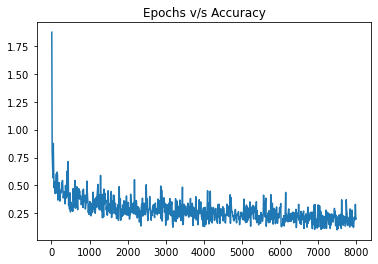

In [12]:
show_plot(counter, loss_history, "loss")

Epoch 1
-----------------------------
Epoch Accuracy: 50.24154589371981
Epoch Loss: 1.0211371366794293

Best test acc: 50.24154589371981

Saving best model for epoch: 1

Epoch 2
-----------------------------
Epoch Accuracy: 49.75845410628019
Epoch Loss: 0.6137753977225378
Epoch 3
-----------------------------
Epoch Accuracy: 48.429951690821255
Epoch Loss: 0.5742259277747228
Epoch 4
-----------------------------
Epoch Accuracy: 50.24154589371981
Epoch Loss: 0.5163187843102676
Epoch 5
-----------------------------
Epoch Accuracy: 50.0
Epoch Loss: 0.5208591199838198
Epoch 6
-----------------------------
Epoch Accuracy: 51.20772946859904
Epoch Loss: 0.4967723488807678

Best test acc: 51.20772946859904

Saving best model for epoch: 6

Epoch 7
-----------------------------
Epoch Accuracy: 48.671497584541065
Epoch Loss: 0.4748906447337224
Epoch 8
-----------------------------
Epoch Accuracy: 50.72463768115942
Epoch Loss: 0.4386327266693115
Epoch 9
-----------------------------
Epoch Accuracy:

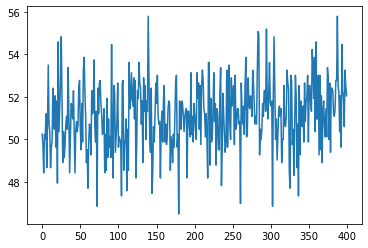

In [8]:
# New training loop 
train_acc = []
train_loss = []
save_best_model = SaveBestModel()

for t in range(no_epochs):
    print(f'Epoch {t+1}\n-----------------------------')
    train_epoch_acc, train_epoch_loss = train(train_dataloader,model_trained,criterion ,optimizer)
    train_acc.append(train_epoch_acc)
    train_loss.append(train_epoch_loss)
    print(f"Epoch Accuracy: {train_epoch_acc}")
    print(f"Epoch Loss: {train_epoch_loss}")
    save_best_model(train_epoch_acc, t, model_trained, optimizer,criterion )
save_model(no_epochs, model_trained, optimizer, criterion )
plt.plot(train_acc,label = "Accuracy\n")

The value of i :- 0


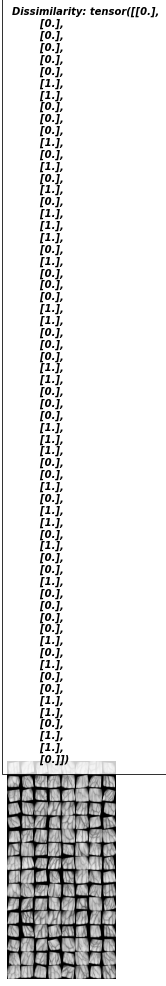

The value of i :- 1


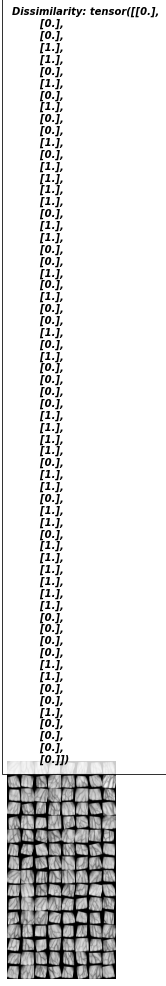

The value of i :- 2


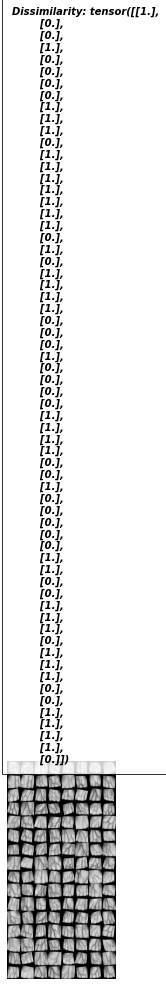

The value of i :- 3


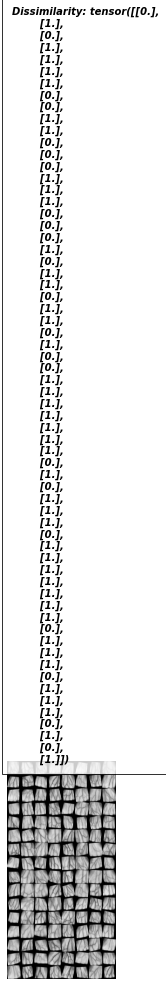

The value of i :- 4


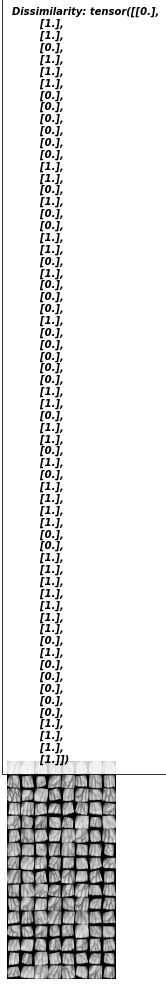

In [ ]:
# for i, (img0, img1, label) in enumerate(train_dataloader, 0):
#     if (i < 5):
#         print("The value of i :-", i)
#         con = torch.cat((img0, img1), 0)
#         imshow(torchvision.utils.make_grid(con),f'Dissimilarity: {label}')
    